In [357]:
# Initial Imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [358]:
#Read in the data and slice out the country we want to research
df = pd.read_csv(
    Path("WEOApr2021all.csv")
)

df = df[(df["Subject Descriptor"]=="Gross domestic product, current prices") & (df["Units"]=="U.S. dollars")]
df.drop(columns=["Subject Descriptor", "Units", "Scale", "Estimates Start After"], inplace=True)
df = df.T
df.columns = df.loc["Country"]
df = df.drop("Country", axis=0)
df.head()

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
WEO Country Code,512,914,612,614,311,213,911,314,193,122,...,111,298,927,846,299,582,487,474,754,698
ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,ABW,AUS,AUT,...,USA,URY,UZB,VUT,VEN,VNM,WBG,YEM,ZMB,ZWE
WEO Subject Code,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,...,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD
Subject Notes,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...
Country/Series-specific Notes,"See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...",...,"See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren..."


# US lstm GDP predictor

In [360]:
# create specific df for country of interest 
US_df = df[['United States']]

US_gdp = US_df.drop(labels=["WEO Country Code", "ISO", "WEO Subject Code", "Subject Notes", "Country/Series-specific Notes"], axis=0)

US_gdp.rename(columns = {'Country':'Year'}, inplace = True)

#convert all data to floats for ease of manipulation
US_gdp = US_gdp.replace(",","", regex=True)
US_gdp = US_gdp.astype("float")
#added a lagged column for preddictions
US_gdp["lagged GDP"] = US_gdp[["United States"]]
#d['gdp'] = df['gdp'].shift(-5)
US_gdp["lagged GDP"] = US_gdp['lagged GDP'].shift(10)

US_gdp

Country,United States,lagged GDP
1980,2857.33,NaN
1981,3207.03,NaN
1982,3343.80,NaN
1983,3634.03,NaN
1984,4037.65,NaN
1985,4339.00,NaN
1986,4579.63,NaN
1987,4855.25,NaN
1988,5236.43,NaN
1989,5641.60,NaN


In [361]:
# use window_data function set up x and y arrays for training
def window_data(US_gdp, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(US_gdp) - window):
        features = US_gdp.iloc[i : (i + window), feature_col_number]
        target = US_gdp.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [362]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 20

feature_column = 0
target_column = 0
X, y = window_data(US_gdp, window_size, feature_column, target_column)
print (f"X sample values:\n{X} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 2857.33  3207.03  3343.8   3634.03  4037.65  4339.    4579.63  4855.25
   5236.43  5641.6   5963.13  6158.13  6520.33  6858.55  7287.25  7639.75
   8073.13  8577.55  9062.83  9630.7 ]
 [ 3207.03  3343.8   3634.03  4037.65  4339.    4579.63  4855.25  5236.43
   5641.6   5963.13  6158.13  6520.33  6858.55  7287.25  7639.75  8073.13
   8577.55  9062.83  9630.7  10252.35]
 [ 3343.8   3634.03  4037.65  4339.    4579.63  4855.25  5236.43  5641.6
   5963.13  6158.13  6520.33  6858.55  7287.25  7639.75  8073.13  8577.55
   9062.83  9630.7  10252.35 10581.83]
 [ 3634.03  4037.65  4339.    4579.63  4855.25  5236.43  5641.6   5963.13
   6158.13  6520.33  6858.55  7287.25  7639.75  8073.13  8577.55  9062.83
   9630.7  10252.35 10581.83 10936.45]
 [ 4037.65  4339.    4579.63  4855.25  5236.43  5641.6   5963.13  6158.13
   6520.33  6858.55  7287.25  7639.75  8073.13  8577.55  9062.83  9630.7
  10252.35 10581.83 10936.45 11458.25]
 [ 4339.    4579.63  4855.25  5236.43  5641.6   59

In [363]:
# Use 90% of the data for training and the remainder for testing
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split - 20:]
y_train = y[: split]
y_test = y[split - 20:]

In [364]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [365]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.03191488]
  [0.0121629 ]
  [0.02552812]
  [0.03643174]
  [0.02750949]
  [0.02147792]
  [0.02372472]
  [0.03195251]
  [0.03296517]
  [0.02552494]
  [0.01525586]
  [0.02706045]
  [0.02400162]
  [0.02941402]
  [0.02491874]
  [0.02882375]
  [0.03166365]
  [0.0297443 ]
  [0.03394871]
  [0.03637735]]

 [[0.04439701]
  [0.03797294]
  [0.06102983]
  [0.06363234]
  [0.04947601]
  [0.04607894]
  [0.05653579]
  [0.06591598]
  [0.05912528]
  [0.04100518]
  [0.04359265]
  [0.05232931]
  [0.05442411]
  [0.0535998 ]
  [0.05555501]
  [0.0623723 ]
  [0.06212584]
  [0.06455079]
  [0.07111254]
  [0.05565767]]

 [[0.07088444]
  [0.0738667 ]
  [0.08753605]
  [0.0853522 ]
  [0.074636

In [366]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [367]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.4

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))


model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer


model.add(Dense(1))

In [368]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics= ["accuracy"])

In [369]:
# Summarize the model
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 20, 5)             140       
_________________________________________________________________
dropout_45 (Dropout)         (None, 20, 5)             0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 20, 5)             220       
_________________________________________________________________
dropout_46 (Dropout)         (None, 20, 5)             0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_47 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

In [381]:
# Train the model
model.fit(X_train, y_train, epochs=1000, shuffle=False, batch_size=1, verbose=1)

Epoch 1/1000
24/24 [==============================] - 1s 6ms/step - loss: 0.0216 - accuracy: 0.0417
Epoch 2/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.0417
Epoch 3/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0289 - accuracy: 0.0417
Epoch 4/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.0417
Epoch 5/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0076 - accuracy: 0.0417
Epoch 6/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.0417
Epoch 7/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0179 - accuracy: 0.0417
Epoch 8/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 0.0417
Epoch 9/1000
24/24 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.05 - 0s 6ms/step - loss: 0.0464 - accuracy: 0.0417
Epoch 10/1000
24/24 [==============================] - 0s 

In [382]:
# Evaluate the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.0052 - accuracy: 0.0435


[0.005177838262170553, 0.043478261679410934]

In [383]:
#get prediction from the X_test
predicted = model.predict(X_test)


In [384]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [385]:
predicted_prices.ravel().shape

(23,)

In [386]:
# Create a DataFrame of Real and Predicted values
GDP = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
GDP

,Real,Predicted
2004,12213.73,13192.496094
2005,13036.63,13608.488281
2006,13814.60,13991.513672
2007,14451.88,14351.988281
2008,14712.83,14701.124023
2009,14448.93,15046.586914
2010,14992.05,15394.250000
2011,15542.60,15753.807617
2012,16197.05,16139.133789
2013,16784.83,16557.720703


<AxesSubplot:>

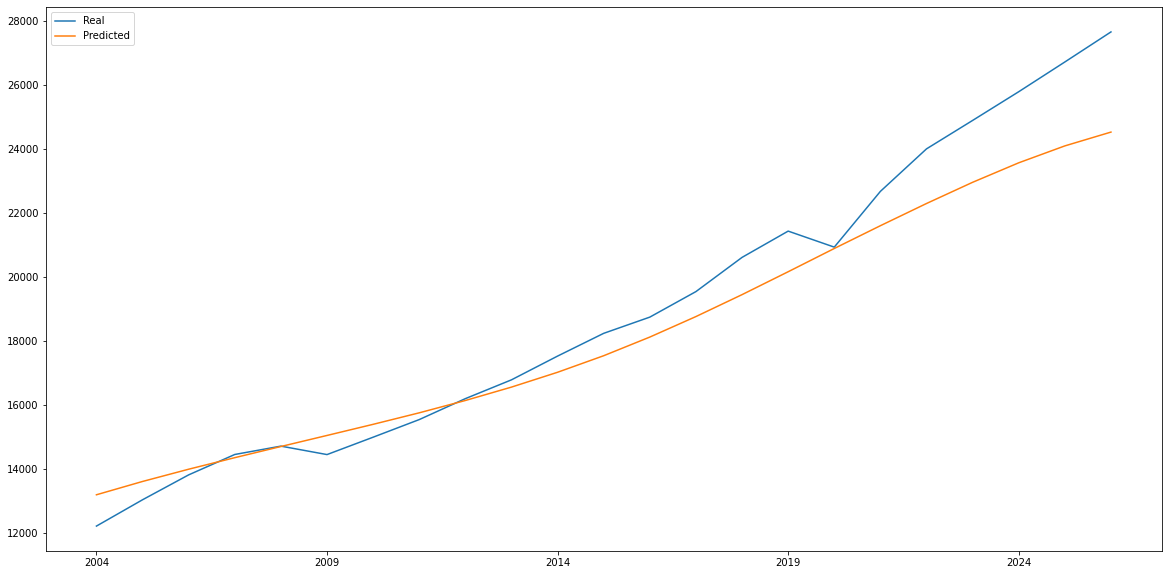

In [387]:
# Plot the real vs predicted prices as a line chart
GDP.plot(figsize=(20,10))

# R2 Score

In [388]:
from sklearn.metrics import r2_score

In [389]:
y_true = GDP['Real']
y_pred = GDP['Predicted']

In [390]:
r2_score(y_true, y_pred)

0.9245409089735842